In [2]:
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pylab as plt

import theano.tensor as tt
from theano.tensor import slinalg
cholesky = slinalg.cholesky
from theano import scan, shared

from pymc3 import Model, sample, Metropolis, advi, Deterministic, Mixture
from pymc3 import DensityDist, CategoricalGibbsMetropolis, Minibatch, logsumexp
from pymc3.distributions import *
from pymc3.gp import cov, gp, mean
from pymc3 import ADVI, adam, fit, SVGD, sgd
from pymc3 import forestplot, traceplot

from scipy.interpolate import interp1d
import scipy as sp

In [3]:
DATA_DIR = '../data/clean/'

In [4]:
bmi_by_patient = (pd.read_csv(DATA_DIR+'bmi_by_patient.csv', index_col=0)
                      .dropna(axis=1, thresh=5))
bmi_by_patient.head()

,1621101,1685338,1713205,1958537,2025534,2062537,2087799,2129427,2186450,2382232,...,40985475,41005570,41014622,41014655,41043167,41052325,41054388,41077231,41087032,41248451
Days,,,,,,,,,,,,,,,,,,,,,
0,27.464844,NaN,29.679341,27.51063,27.032689,27.484552,29.380994,27.614212,29.743767,28.201669,...,27.777479,29.785761,28.921647,NaN,28.096818,28.663549,27.26058,27.125971,27.423469,28.801188
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,29.785761,NaN,NaN,NaN,NaN,NaN,NaN,NaN,28.695456
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,29.969401,NaN,NaN,NaN,NaN,NaN,NaN,NaN,29.209745
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,29.030746,NaN,NaN,NaN,NaN,NaN,NaN,28.695456
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
#bmi_by_patient.index = pd.Series(bmi_by_patient.index).apply(partial(pd.Timedelta, unit='D'))
bmi_by_patient.index =  pd.to_datetime(bmi_by_patient.index, unit='D')

In [6]:
bmi_resampled = bmi_by_patient.resample('2W').mean()
bmi_resampled.shape

(27, 5915)

In [7]:
# data_subset = bmi_resampled.iloc[:, :500]
data_subset = bmi_resampled.copy()

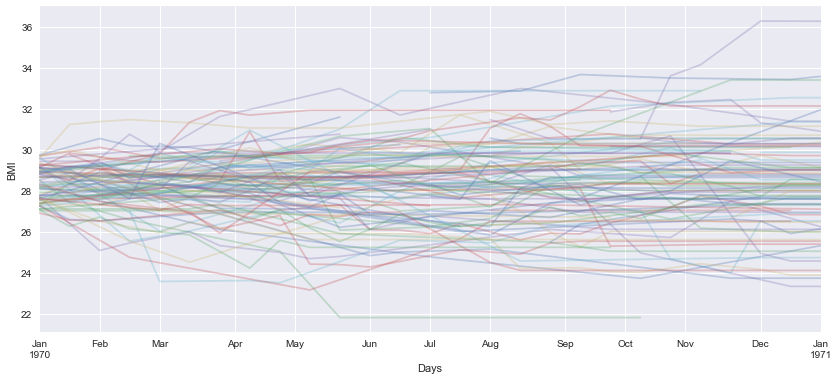

In [8]:
fig, axes = plt.subplots(figsize=(14,6))
(bmi_resampled[np.random.choice(bmi_resampled.columns, 100)].interpolate(limit=10)
            .plot(legend=False, alpha=0.3, ax=axes))
axes.set_ylabel('BMI');

In [9]:
data_subset.shape

(27, 5915)

Stick-breaking function for Dirichlet process

In [10]:
def stick_breaking(beta):
    
    portion_remaining = tt.concatenate([[1], tt.extra_ops.cumprod(1 - beta)[:-1]])

    return beta * portion_remaining

Maximum number of groups

In [11]:
CLUSTERS = 20
DATES, PATIENTS = data_subset.shape

In [12]:
KNOTS = 8
knots = np.linspace(0, data_subset.shape[0]-1, KNOTS)

basis_funcs = sp.interpolate.BSpline(knots, np.eye(KNOTS), k=3)

In [13]:
data_masked = np.ma.masked_values(data_subset.fillna(100).values.T, value=100)

In [14]:
APPROX = True

if APPROX:
    BATCH_SIZE = 10
    minibatches = Minibatch(data_masked, batch_size=BATCH_SIZE)
else:
    BATCH_SIZE = N
    minibatches = data_missing

X = np.arange(DATES).reshape(-1, 1)

In [16]:
with Model() as model:
    
    # Dirichlet process for clusters
    α = Gamma('α', 1., 1.)
    β = Beta('β', 1., α, shape=CLUSTERS)
    ω = Deterministic('ω', stick_breaking(β))
        
    # Gaussian random walks models
    σ_a = HalfCauchy('σ_a', 1)

    start = Normal('start', 28, sd=2, shape=CLUSTERS)
    a = Normal('a', mu=0, sd=1, shape=(CLUSTERS, KNOTS))
    θ = Deterministic('θ', (start + (σ_a * a.T).cumsum(1)).T)
    
    # Observation noise
    σ = HalfCauchy('σ', 5)
    
    # Spline basis functions
    Bx = shared(basis_funcs(np.arange(DATES)))
    
    # Mixture of random walks
    def logp(value):
        def calc_logp(theta, sd):
            return Normal.dist(tt.flatten(Bx.dot(theta)), 
                                 sd=sd, 
                                 shape=(BATCH_SIZE, DATES)).logp(value).sum()
        prob, _ = scan(calc_logp, sequences=[θ], non_sequences=[σ])
        return logsumexp(tt.log(ω) + prob.T, axis=-1)

    
    trajectories = DensityDist('trajectories', logp, observed=minibatches, total_size=(PATIENTS, DATES))
    

In [27]:
with model:
    if APPROX:
#         approx = fit(n=20000)
        approx = fit(500, method='svgd', 
                         inf_kwargs=dict(n_particles=1000, jitter=1), 
                         obj_optimizer=sgd())
        trace = approx.sample(1000)
    else:
        trace = sample(1000, tune=4000, n_init=50000)

  0%|          | 1/500 [00:01<10:24,  1.25s/it]


FloatingPointError: NaN occurred in optimization.

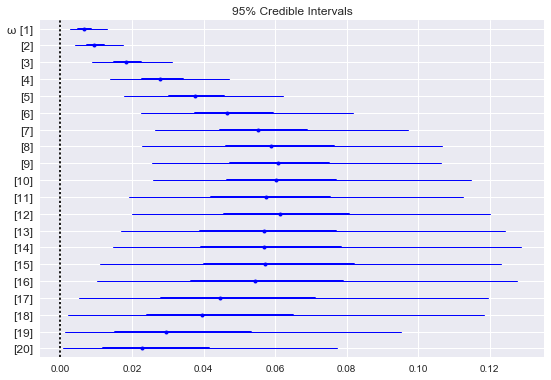

In [19]:
forestplot(trace, varnames=['ω'])

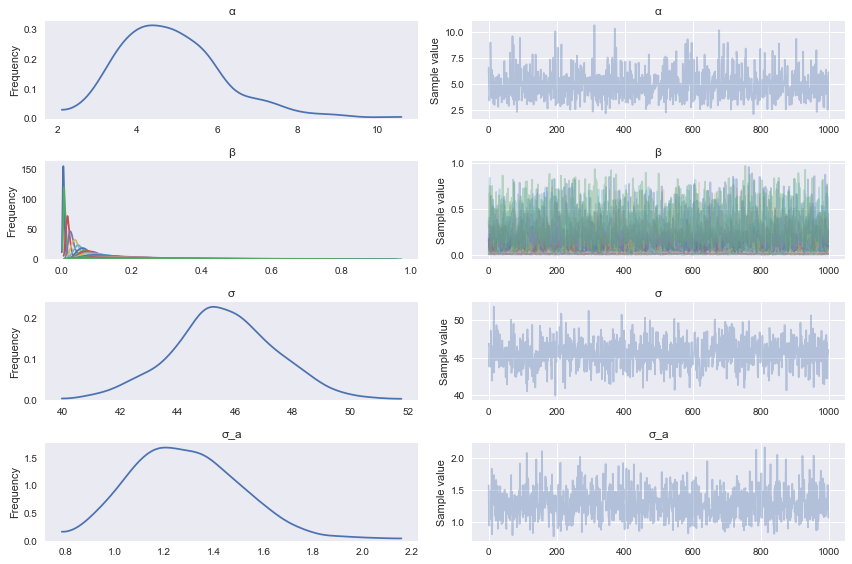

In [20]:
traceplot(trace, varnames=['α', 'β', 'σ', 'σ_a']);

In [22]:
thetas = trace['θ']

In [23]:
thetas.shape

(1000, 20, 8)

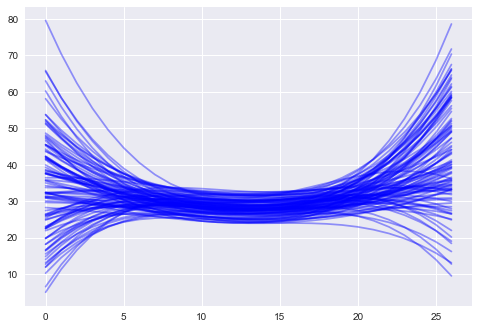

In [24]:
plt.plot(basis_funcs(np.arange(DATES)).dot(thetas[-100:, 0].T), color='blue', alpha=0.4);

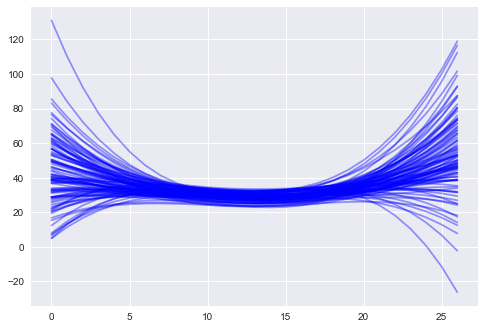

In [25]:
plt.plot(basis_funcs(np.arange(DATES)).dot(thetas[-100:, 1].T), color='blue', alpha=0.4);

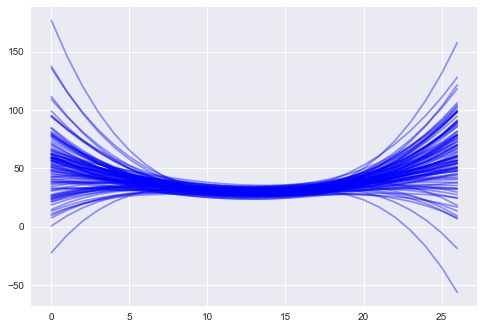

In [26]:
plt.plot(basis_funcs(np.arange(DATES)).dot(thetas[-100:, 2].T), color='blue', alpha=0.4);